100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training Teacher Model...


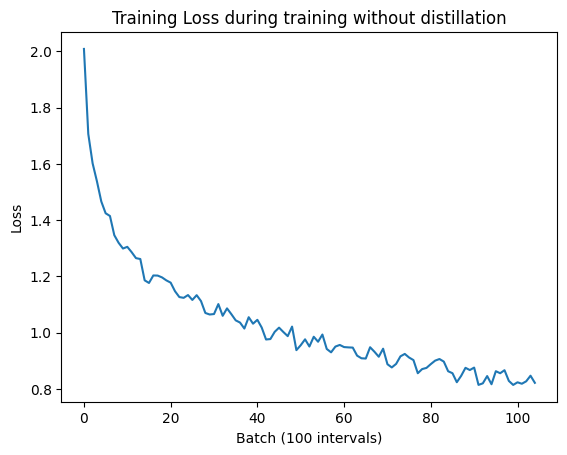

Teacher model testing:
Accuracy: 64.7%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.view(-1, 16 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def train_teacher(model, optimizer, criterion, epochs=15):
    model.train()
    training_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                #print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                training_losses.append(running_loss / 100)
                running_loss = 0.0
    # Plotting training loss over time
    plt.plot(training_losses)
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title('Training Loss during training without distillation')
    plt.show()

def test_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
    print(f'Accuracy: {100. * correct / len(test_loader.dataset)}%')

teacher_model = TeacherModel().to(device)
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Teacher Model...")
train_teacher(teacher_model, teacher_optimizer, criterion)
print("Teacher model testing:")
test_model(teacher_model)

Training Student Model with Distillation...
Epoch [1/15], Batch [100/782], Loss: 4.0000
Epoch [1/15], Batch [200/782], Loss: 2.6909
Epoch [1/15], Batch [300/782], Loss: 2.2207
Epoch [1/15], Batch [400/782], Loss: 2.0239
Epoch [1/15], Batch [500/782], Loss: 1.8179
Epoch [1/15], Batch [600/782], Loss: 1.7002
Epoch [1/15], Batch [700/782], Loss: 1.6300
Epoch [2/15], Batch [100/782], Loss: 1.4942
Epoch [2/15], Batch [200/782], Loss: 1.4518
Epoch [2/15], Batch [300/782], Loss: 1.4360
Epoch [2/15], Batch [400/782], Loss: 1.4184
Epoch [2/15], Batch [500/782], Loss: 1.4094
Epoch [2/15], Batch [600/782], Loss: 1.3897
Epoch [2/15], Batch [700/782], Loss: 1.3757
Epoch [3/15], Batch [100/782], Loss: 1.3353
Epoch [3/15], Batch [200/782], Loss: 1.3202
Epoch [3/15], Batch [300/782], Loss: 1.2995
Epoch [3/15], Batch [400/782], Loss: 1.3172
Epoch [3/15], Batch [500/782], Loss: 1.3047
Epoch [3/15], Batch [600/782], Loss: 1.3094
Epoch [3/15], Batch [700/782], Loss: 1.3173
Epoch [4/15], Batch [100/782], L

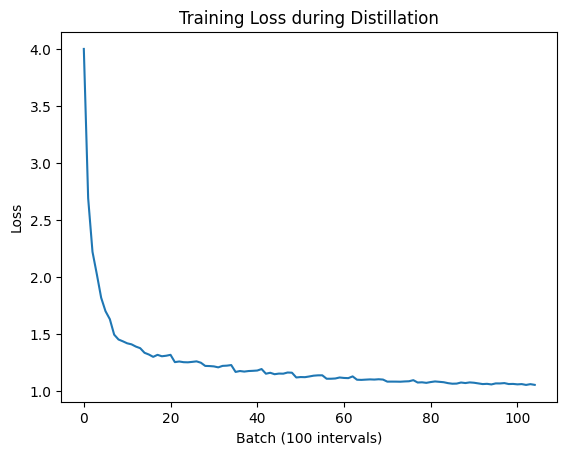

Student model testing with distillation:
Accuracy: 72.05%
Training Student Model without Distillation...


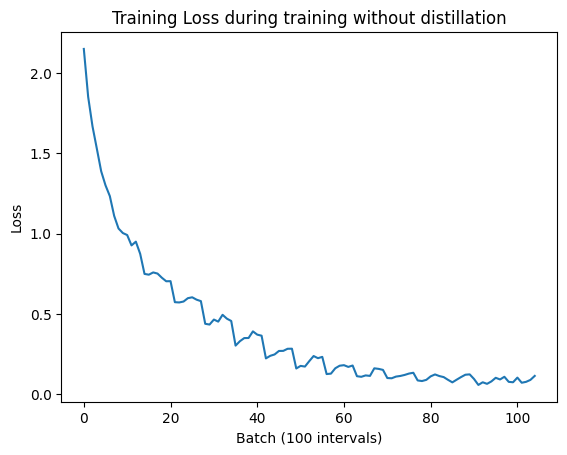

Student model testing without distillation:
Accuracy: 76.11%


In [2]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = x.view(-1, 512 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

def train_student(student_model, teacher_model, optimizer, temperature=7.0, alpha=0.6, epochs=15):
    student_model.train()
    teacher_model.eval()
    training_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Teacher outputs with temperature
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs) / temperature

            # Student outputs
            student_outputs = student_model(inputs) / temperature

            # Hard and soft losses
            loss_hard = criterion(student_outputs, targets)
            loss_soft = F.kl_div(F.log_softmax(student_outputs, dim=1),
                                 F.softmax(teacher_outputs, dim=1),
                                 reduction='batchmean')

            # Combined loss
            loss = alpha * loss_hard + (1 - alpha) * loss_soft * (temperature ** 2)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                training_losses.append(running_loss / 100)
                running_loss = 0.0

    plt.plot(training_losses)
    plt.xlabel('Batch (100 intervals)')
    plt.ylabel('Loss')
    plt.title('Training Loss during Distillation')
    plt.show()

student_model = StudentModel().to(device)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
print("Training Student Model with Distillation...")
train_student(student_model, teacher_model, student_optimizer)

print("Student model testing with distillation:")
test_model(student_model)

student_model_no_distill = StudentModel().to(device)
student_optimizer_no_distill = optim.Adam(student_model_no_distill.parameters(), lr=0.001)
print("Training Student Model without Distillation...")
train_teacher(student_model_no_distill, student_optimizer_no_distill, criterion)

print("Student model testing without distillation:")
test_model(student_model_no_distill)


Training Student Model with Distillation... 2
Epoch [1/15], Batch [100/782], Loss: 4.1055
Epoch [1/15], Batch [200/782], Loss: 2.9155
Epoch [1/15], Batch [300/782], Loss: 2.4067
Epoch [1/15], Batch [400/782], Loss: 2.1619
Epoch [1/15], Batch [500/782], Loss: 1.9587
Epoch [1/15], Batch [600/782], Loss: 1.8615
Epoch [1/15], Batch [700/782], Loss: 1.6958
Epoch [2/15], Batch [100/782], Loss: 1.5515
Epoch [2/15], Batch [200/782], Loss: 1.5182
Epoch [2/15], Batch [300/782], Loss: 1.4743
Epoch [2/15], Batch [400/782], Loss: 1.4483
Epoch [2/15], Batch [500/782], Loss: 1.4382
Epoch [2/15], Batch [600/782], Loss: 1.4180
Epoch [2/15], Batch [700/782], Loss: 1.4063
Epoch [3/15], Batch [100/782], Loss: 1.3354
Epoch [3/15], Batch [200/782], Loss: 1.3481
Epoch [3/15], Batch [300/782], Loss: 1.3339
Epoch [3/15], Batch [400/782], Loss: 1.3125
Epoch [3/15], Batch [500/782], Loss: 1.3230
Epoch [3/15], Batch [600/782], Loss: 1.3194
Epoch [3/15], Batch [700/782], Loss: 1.3247
Epoch [4/15], Batch [100/782],

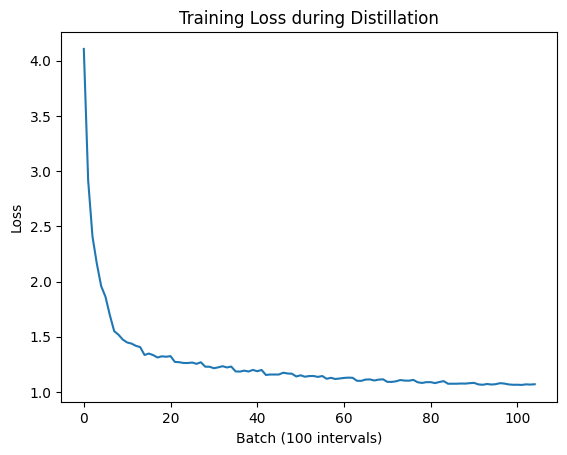

Student model testing with distillation: 2
Accuracy: 71.65%
Training Student Model without Distillation... 2


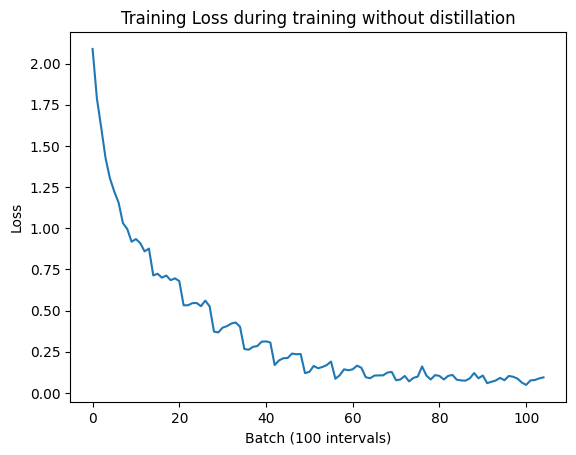

Student model testing without distillation: 2
Accuracy: 74.28%


In [3]:
student_model = StudentModel().to(device)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
print("Training Student Model with Distillation... 2")
train_student(student_model, teacher_model, student_optimizer)

print("Student model testing with distillation: 2")
test_model(student_model)

student_model_no_distill = StudentModel().to(device)
student_optimizer_no_distill = optim.Adam(student_model_no_distill.parameters(), lr=0.001)
print("Training Student Model without Distillation... 2")
train_teacher(student_model_no_distill, student_optimizer_no_distill, criterion)

print("Student model testing without distillation: 2")
test_model(student_model_no_distill)